# Building a Corporate Valuation Model with Python Pt. II: DCF Method

Having established the database, I will build a corporate valuation model identical to the methods given in [Brigham & Houston ("Fundamentals of Financial Management", 6th ed., 2009, South Western Cengage Learning, pp. 288 and pp. 306)](https://www.valorebooks.com/textbooks/fundamentals-of-financial-management-concise-edition-with-thomson-one-business-school-edition-6th-edition/9780324664553). Additionally, one can check the [this source](https://corporatefinanceinstitute.com/resources/knowledge/modeling/dcf-model-training-free-guide/), too, for further insights on the topic of corporate valuation.

Before starting the analysis we need some general assumptions and information on data in order to implement the DCF method for company valuation. We need the _after-tax cost of debt_ for the specific company as well as the _cost of its equity_. As for the debt it is quite cumbersome to get the individual firm´s cost of debt - either we would need to check the annual reports of that company or be lucky and find a free platform that offers such an information for any possible company. Both methods are difficult to implement in a dynamic and automated manner within a python script; I would need to build an extra scraper just to retrieve such an information for any possible firm. And I barely believe that there is a free source for that.

<u><h4><font color="#ab4e52">Cost of Debt Estimate</font></h4></u>

Hence, I will **use the [central bank information on interest rates](https://sdw.ecb.europa.eu/browse.do?node=bbn2883) of new loans (>1 EURm) for non-financial corporations** and retrieve interest rate time series data from the `ECB SDM 2.1 RESTful web service` through making a **http get request**. Basically, it is like a function replicating the [sdw_api python package from the ECB](https://pypi.org/project/sdw-api/), but is more flexible in the sense that it does not throw an error for the retrieved data if different time series are imported, which was the case for the api package.

The standard entrypoint for the **ECB SDMX 2.1 RESTful web service** is `https://sdw-wsrest.ecb.europa.eu/service/data/`.<br>
We then make an empty list in which we will store each individual dataframe which we will have received from the https get request on basis of the time series keys in 'keys_list'. Specifically, I will use the **key 'MIR.M.U2.B.A2A.O.R.1.2240.EUR.N'** which identifies the data on `Bank interest rates - loans to corporations of over EUR 1M with an IRF period of over five & up to ten years (new business) - euro area`. Nonetheless, I will write a function that is general enough to iterate across a list of keys and get an average estimate of the interest rate level.

In essence, the function `get_ir_data()` is general enough in order to retrieve ECB data for any key in the `key_list` (e.g. also keys for the yield curve or exchange rates).

<u><h4><font color="#ab4e52">Cost of Equity Estimate</font></h4></u>

As for the cost of equity I will follow the <span style="color:orange"><b>CAPM Approach</b></span>, i.e. use the current ECB interest rate for main refinancing operations (1.25%, 2022/09/17) as **risk-free rate** and calculate the **annualized market risk premium** from the historical price data of the respective stock index, in our case the 'DAX'. The **beta coefficient** of the individual company is retrieved from the `FMP API` while we use `yahoo finance API` for **historical price data of the respective index**.

### Preliminary Definitions

In [1]:
#=============SET UP LOGGING ======================#
import logging
import sys
# specifically for pyplot: https://stackoverflow.com/questions/56618739/matplotlib-throws-warning-message-because-of-findfont-python
logging.getLogger('matplotlib').disabled = True

logger=logging.getLogger()
formatter = logging.Formatter('%(asctime)s - %(name)s - %(lineno)s - %(levelname)s - %(message)s')
logger.setLevel(logging.DEBUG)

# set logging handler in file
fileHandler=logging.FileHandler(filename="log/cvm_main.log", mode='w')
fileHandler.setFormatter(formatter)
fileHandler.setLevel(logging.DEBUG)
logger.addHandler(fileHandler)

# set logging handler in console
consoleHandler=logging.StreamHandler(sys.stdout)
consoleHandler.setFormatter(formatter)
consoleHandler.setLevel(logging.INFO)
logger.addHandler(consoleHandler)
#===================================================#

In [2]:
#--- PRELIMINARY IMPORTS -------------------------------------#
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [3]:
# define which company we want to focus on - This parameter is essential for the WebAPP we might build in the future --> with a dropdown value which is assigned to this variable
# such that the user can choose many different companies
# Possible companies:
# ADIDAS AG, AIRBUS SE, ALLIANZ SE, BASF SE, 
# BAYER AG, BEIERSDORF AG O.N., BAYERISCHE MOTOREN WERKE AG, BRENNTAG SE NA O.N., 
# CONTINENTAL AG, COVESTRO AG, Delivery Hero SE Namens-Aktien, DEUTSCHE BANK AG, 
# DEUTSCHE BOERSE NA O.N., DEUTSCHE POST AG, DEUTSCHE TELEKOM AG, E.ON SE, FRESENIUS MEDICAL CARE AG & CO, 
# FRESENIUS SE&CO KGAA, HEIDELBERGCEMENT AG O.N., HELLOFRESH SE INH O.N., HENKEL AG&CO. KGAA, 
# INFINEON TECHNOLOGIES AG, LINDE PLC EO 0,001, MERCEDES-BENZ GROUP, MERCK KGAA, 
# MTU AERO ENGINES NA O.N., MUENCHENER RUECKVERSICHERUNGS A, PORSCHE AUTOM.HLDG VZO,
# PUMA SE, Qiagen N.V., RWE AG INH O.N., SAP SE, SARTORIUS AG VZO O.N., SIEMENS AG, 
# SIEMENS ENERGY AG NA O.N., SIEMENS HEALTH.AG NA O.N., SYMRISE AG INH. O.N., VOLKSWAGEN AG, VONOVIA SE NA O.N., ZALANDO SE
global company
company='E.ON SE' # Currently, I have just a limited amount of companies in the database. The companies are: GitLab Inc., INFINEON TECHNOLOGIES AG, E.ON SE, Palantir Technologies Inc.,
  
companyTicker_dict = json.load(open('ticker_dict.json', 'r'))

ticker=companyTicker_dict[company]

### Calculate After-Tax Debt Cost

In [5]:
# To make web requests at the ECB SDMX 2.1 RESTful web service
import requests

# For use of the ECB API
#from sdw_api import SDW_API

# Standard libs for data manipulation
import numpy as np
import scipy.stats as st
import io
import datetime
from datetime import date
import re
import ValuationModel
from ValuationModel.assist_functions import *
from ValuationModel.fmp import *
from config.api import MY_API_KEY
from ValuationModel.arima import *

In [5]:
# Key List
keys_list=pd.read_excel('assets/keys_IR.xlsx')['Keys'].tolist()
# Set start period for time series as a string value, e.g., '2019-12-01' 
start='2022-01-01'
interest_df=get_ir_data(keys_list, start)
interest_df.to_csv("data/interest_df.csv")
debt_cost=(interest_df['OBS_VALUE'].iloc[-1])/100
# German Corporate Tax rate (incl. solidarity surcharge) = 15.825%
tax=0.15825
at_debt_cost=debt_cost*(1-tax)
at_debt_cost

0.0313131

### Calculate Market Risk Premium (MRP)

In [6]:
index_table=get_index_table()
index_table.to_csv("data/index_list_overview.csv")

In [7]:
#'^GSPC', '^FTSE', '^NDX', '^RUA', '^NYA'] # Dax Performance40, S&P500, FTSE100, Nasdaq100, Dow Jones
# Retrieve Data on the DAX Performance Index (i.e. the 40 stocks which I have in my database)
from yahoofinancials import YahooFinancials
# Get most recent week’s minute data
today = date.today()        # get the date of today
today_formatted = today.strftime("%Y-%m-%d")
dax_perf_prices = YahooFinancials('^GDAXI').get_historical_price_data('2010-01-01', end_date=today_formatted, time_interval='daily')
#dax_perf_prices = pd.DataFrame.from_dict(pd.json_normalize(dax_perf_prices), orient="columns")
entry=extract_json(dax_perf_prices, ['prices'])
entry=entry[0]['prices']
index=pd.DataFrame(entry)
#dax=get_price_table('DAX', json_entry='historical')
dax_perf_closep=index[['close']]
#--- ANNUALIZE THE DAILY RETURNS --------------------------------------------------------------#
days=len(dax_perf_closep)
# Total Return over the period
total_return=(dax_perf_closep.iloc[-1] - dax_perf_closep.iloc[0]) / dax_perf_closep.iloc[0]
annualized_return=((1+total_return)**(252/days))-1
#--- RISK-FREE RATE = ECB MAIN REFINANCING RATE -----------------------------------------------#
# Get ECB Main refinancing rate from SDW API.
# ECB series key: FM.B.U2.EUR.4F.KR.MRR_FR.LEV
ecb_r_key=['FM.B.U2.EUR.4F.KR.MRR_FR.LEV']
ecb_rate_df=get_ir_data(ecb_r_key, start)
rfr=float(ecb_rate_df['OBS_VALUE'].iloc[-1])/100
mrp=float(annualized_return-rfr)
print("\nThe market risk premium (MRP):\n-------------------------------\n",mrp)


The market risk premium (MRP):
-------------------------------
 0.03936824731556579


### Retrieve Fundamental Financial Data Tables from our PostgreSQL Database (see Pt. I)

In [8]:
#---- DATABASE MANAGEMENT TOOLS --------------#
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras as extras

#---- DATA MANIPULATION TOOLS ----------------#
import pandas_datareader as dr

#---- OWN MODULE IMPORTS --------------------#
import config.pw

In [9]:
# Set necessary url variables for the sqlalchemy create_engine() method.
user='svenst89' # or default user 'postgres'
password=config.pw.password # edit the password if you switch to the default user 'postgres'; I setup different passwords.
host='localhost'
port='5432'
database='fundamentalsdb'

In [10]:
# Create an engine object as medium for database exchange with PostgreSQL
global engine
def run_engine():
    return create_engine(f"postgresql://{user}:{password}@{host}:{port}/{database}")
if __name__=='__main__':
    try:
        engine=run_engine()
        print(f"You have successfully created an engine object for your Postgres DB at {host} for user {user}!")
    except Exception as ex:
        print("Sorry your engine has not been created. Some exception has occurred. Please check and try it again!\n", ex)

You have successfully created an engine object for your Postgres DB at localhost for user svenst89!


The following function retrieves our previously stored fundamental financial statement data from our **PostgreSQL** database with a simple _SQL query_ with a `WHERE` constraint. Later on we can use a for-loop to iterate across the companies, if we want to.

In [11]:
#===OPTIONAL: INSTEAD OF USING FUNCTION 'get_database_findata_year()' use the general function retrieving all available financial data and extracting a specific year from the whole dataframe
bs, incs, cs = get_database_findata(company, engine)
year=2022 #get_latest_available_fy(ticker, json_entry="date")
bs_y=clearDataframes_and_get_fy(company, bs, 'bs', year)
incs_y=clearDataframes_and_get_fy(company, incs, 'incs', year)
cs_y=clearDataframes_and_get_fy(company, cs, 'cs', year)
bs

You have successfully retrieved the financial statement data for company 'E.ON SE'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Income Statement and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Cashflow Statement and extracted financial data for Fiscal Year (FY) 2022.



,id,shortname,date,item,value,company_id
0,1813,E.ON SE,2021-12-31,inventory,1051000000,3
1,1802,E.ON SE,2021-12-31,calendarYear,2021,3
2,1803,E.ON SE,2021-12-31,period,FY,3
3,1804,E.ON SE,2021-12-31,symbol,EOAN.DE,3
4,1805,E.ON SE,2021-12-31,reportedCurrency,EUR,3
...,...,...,...,...,...,...
1320,3122,E.ON SE,1997-12-31,totalInvestments,0,3
1321,3123,E.ON SE,1997-12-31,totalDebt,2278270449,3
1322,3124,E.ON SE,1997-12-31,netDebt,1924816257,3
1323,3125,E.ON SE,1997-12-31,link,https://www.bundesanzeiger.de/pub/de/suche;www...,3


In [12]:
df_year=bs[bs['date'].str.contains(f'{year}')]
if df_year.shape[0]==0:
    df_year=bs[bs['date'].str.contains(f'{year-1}')]


In [13]:
df_year

,id,shortname,date,item,value,company_id
0,1813,E.ON SE,2021-12-31,inventory,1051000000,3
1,1802,E.ON SE,2021-12-31,calendarYear,2021,3
2,1803,E.ON SE,2021-12-31,period,FY,3
3,1804,E.ON SE,2021-12-31,symbol,EOAN.DE,3
4,1805,E.ON SE,2021-12-31,reportedCurrency,EUR,3
5,1806,E.ON SE,2021-12-31,cik,None,3
6,1807,E.ON SE,2021-12-31,fillingDate,2021-12-31,3
7,1808,E.ON SE,2021-12-31,acceptedDate,2021-12-30 19:00:00,3
8,1809,E.ON SE,2021-12-31,cashAndCashEquivalents,3634000000,3
9,1810,E.ON SE,2021-12-31,shortTermInvestments,1596000000,3


In [14]:
df_year=df_year.sort_values(by=['date'], ascending=False)
df_year_clean = df_year[df_year.item.isin(values) == False] # masking: exclude all rows that contain the values in list 'values' above.
df_year_clean['value'] = df_year_clean['value'].astype(float)
df_year_clean_unique=df_year_clean.drop_duplicates(['date', 'item', 'value'], keep='last')
df_year

,id,shortname,date,item,value,company_id
0,1813,E.ON SE,2021-12-31,inventory,1051000000,3
27,1829,E.ON SE,2021-12-31,deferredRevenue,0,3
29,1831,E.ON SE,2021-12-31,totalCurrentLiabilities,40511000000,3
30,1832,E.ON SE,2021-12-31,longTermDebt,0,3
31,1833,E.ON SE,2021-12-31,deferredRevenueNonCurrent,3448000000,3
32,1834,E.ON SE,2021-12-31,deferredTaxLiabilitiesNonCurrent,2649000000,3
33,1835,E.ON SE,2021-12-31,otherNonCurrentLiabilities,55262000000,3
34,1836,E.ON SE,2021-12-31,totalNonCurrentLiabilities,61359000000,3
35,1837,E.ON SE,2021-12-31,otherLiabilities,0,3
36,1838,E.ON SE,2021-12-31,capitalLeaseObligations,0,3


**<u>A brief Note on the Quality of the Data delivered by Financial Modeling Prep (FMP) API</u>**

As for the quality of the data, I made a rough cross-check for the results that `FMP` is offering for **E.ON SE** in the **FY2021**: `FMP` reports a negative **Operating Income** of -11.6 EURbn, whereas E.ON SE reported in its Annual Report 2021 an EBIT ("Ergebnis [...] vor Finanzergebnis und Steuern") of +6.5 EURbn. I checked the Notes of the AR and found that E.ON SE reported in its EBIT special items, i.e. a positive one-off effect, of +45 EURbn from derivative financial income, which does clearly not belong to the usual core business of E.ON SE! If we were to subtract this positive one-off earnings effect "as-if" it would have not incurred, focusing merely on the real operating activities, the EBIT in the Annual Report would not look as "rosy" as presented initially.

Assuming that there are other negative items that should have been added back, I trust the values given by `FMP` that the **Operating Income** was, indeed, negative. So, for my further analysis, I will focus on the 'Operating Income' and/or 'EBITDA' figures as presented by **FMP**.

### Calculate the WACC as discount rate

In [15]:
# The equity required rate of return is calculated and Beta is retrieved inside this function!
wacc=get_wacc(company, year, rfr, mrp, at_debt_cost, engine)
wacc

You have successfully retrieved the financial statement data for company 'E.ON SE'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

You have successfully retrieved the company data for company '   id shortname   symbol               industry     sector currency exchangeshortname  bs_id  is_id  cs_id
0   3   E.ON SE  EOAN.DE  Utilities—Diversified  Utilities      EUR             XETRA   3126   2182   2300'!


0.03224629733235662

### Build up the Forecast Model

For each individual position in our forecast model we need to calculate CAGRs which we then use in order to extrapolate each position into the future and to calculate the **unlevered Free-Cashflow-to-the-Firm** for each future year. For reasons of simplicity we do not average between a terminal Enterprise Value based on an EV/EBITDA multiple and a Terminal Value that is based on a perpetual growth rate - we simply use the method based on a perpetual growth rate. Maybe I will change this in the future.

- For the `perpetual (long-term growth rate)` to calculate the **terminal value** I use a 'tunable' variable, called `g`, which simply is a adjusted WACC rate, i.e. the WACC is adjusted manually by a hypothetical number that allows to reach a 'reasonable' terminal value. If you would take the simple cagr of the revenue development over the last years, you would receive - in most cases - astronomical valuations (it escalates exponentially quite quickly!)

- For 'EBIT' we use `operatingIncomeRatio` from the Income Statement as delivered by FMP and the related average over the last available years and apply it on the extrapolated revenues.

- For 'Cash Taxes' in order to calculate `NOPAT (Net Operating Profit After Tax)` we use the defined tax rate of _15%_ of the German Tax system

- For 'D&A' we use `depreciationAndAmortization` as given in the Income Statement data of FMP, for 'Capex' we use `capitalExpenditure` and for 'Changes in Net Working Capital' we use `changeInWorkingCapital` from the CF Statement as delivered by FMP as a rough estimate. 

- Finally, I use seasonal ARIMA models for the latter variables to complete the forcasts.

Additionally, we extract the **net debt value** as given by `FMP` for the current fiscal year in order to calculate the **intrinsic Enterprise Value**.

In [16]:
#=== REVENUES: Get the revenues over the last years
rev_df=incs.loc[incs['item']=='revenue'].drop_duplicates(['date', 'value'])
revenues=pd.DataFrame(rev_df['value'])#.values
#date=pd.DataFrame(rev_df['date'])
comp_revs=revenues.set_index(rev_df['date'])#.drop_duplicates(['value'])
comp_revs.to_csv("data/revenue.csv")
#--- REVENUES: Get CAGR
end_val=float(rev_df['value'].iloc[0])
beg_val=float(rev_df['value'].iloc[-1])
n=len(rev_df['date'])
try:
    rev_cagr=((end_val/beg_val)**(1/n))-1
except:
    print("Something went wrong with CAGR calculation! Maybe there are some negative values or zero values at beginning or end?!")
rev_cagr

0.024721518683859856

In [17]:
# Operating Income Margin average over the last years
oir=incs.loc[incs['item']=='operatingIncomeRatio'].drop_duplicates(['date', 'value'])
oir_mean=pd.to_numeric(oir['value']).mean() # first convert string values in column to numeric float
oi=(float(rev_df['value'].iloc[0]))*oir_mean
oir_mean

0.008036249249984724

In [18]:
#=== Depreciation & Amortization (D&A)
comp_dna=prepare_timeseries(incs, item='depreciationAndAmortization')
#=== CAPEX
comp_cex=prepare_timeseries(cs, item='capitalExpenditure')
#=== Change in Working Capital (CWC)
comp_cwc=prepare_timeseries(cs, item='changeInWorkingCapital')

---

<u><b>ARIMA Model for forecasting D&A, CAPEX and ChangeWC</b></u>

<b>D&A</b>

In [19]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')
#plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

In [20]:
# Start with D&A Prediction: Prepare the dataframe with simple "value" column and index from 0 to X
df_dna=comp_dna[['value']].sort_values('date', ascending=True).reset_index().drop(['date'], axis=1)
df_dna

,value
0,2.415452e+09
1,2.829979e+09
2,3.174165e+09
3,4.903128e+09
4,4.460799e+09
5,6.767000e+09
6,3.272000e+09
7,3.256000e+09
8,3.068000e+09
9,3.751000e+09


2023-04-16 14:11:34,152 - root - 122 - INFO - You´ve chosen three orders of Differencing


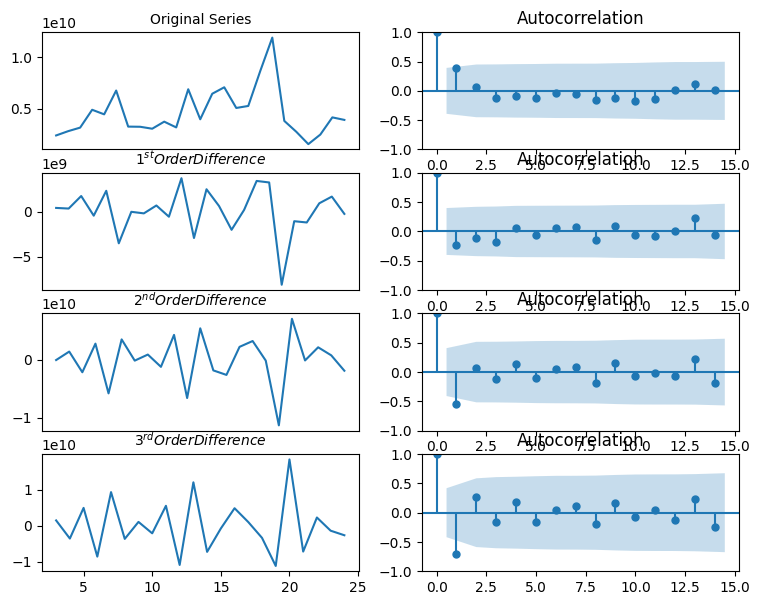

In [21]:
#=========== AUTOCORRELATION PLOT: D&A ==============================#
plot_autocorr(df_dna, diff=3)

In [22]:
dna_sarima, dna_model_summary = build_sarima(df_dna, test_method='adf', frequency=3)
print(dna_model_summary)

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=1029.960, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=1033.343, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=1028.093, Time=0.03 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=1029.414, Time=0.03 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=1031.549, Time=0.00 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=1032.102, Time=0.01 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=1027.821, Time=0.03 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=1029.487, Time=0.04 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=1027.726, Time=0.03 sec
 ARIMA(1,0,0)(0,1,1)[3] intercept   : AIC=1026.092, Time=0.03 sec
 ARIMA(1,0,0)(0,1,2)[3] intercept   : AIC=1027.661, Time=0.03 sec
 ARIMA(1,0,0)(1,1,2)[3] intercept   : AIC=1029.658, Time=0.05 sec
 ARIMA(0,0,0)(0,1,1)[3] intercept   : AIC=1029.267, Time=0.01 sec
 ARIMA(2,0,0)(0,1,1)[3] intercept   : AIC=1028.334, Time=0.03 sec
 ARIMA(2,0,1)(0,1,1)[3] intercept

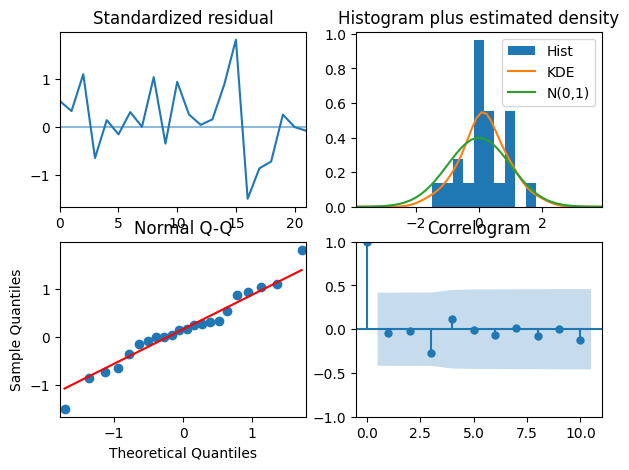

In [23]:
diagnostic_plt(dna_sarima, df_dna)

In [24]:
dna_fc_series=sarima_forecast(dna_sarima, df_dna, num_periods=5, company=company)
dna_fc_list=dna_fc_series.tolist()
dna_fc_list

[3207071311.9978633,
 4581648797.838242,
 4365780199.639175,
 3462008629.9993434,
 4728102010.853675]

<b>CAPEX</b>

2023-04-16 14:11:36,679 - root - 122 - INFO - You´ve chosen three orders of Differencing


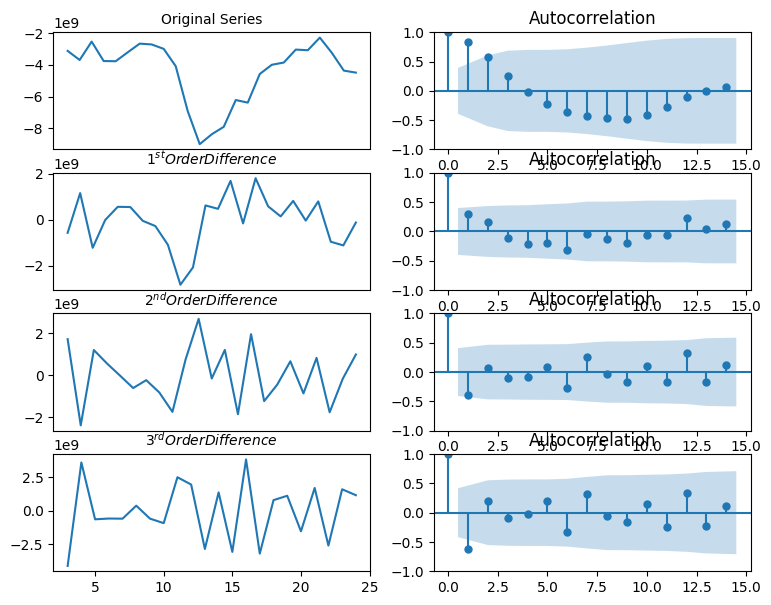

In [25]:
df_cex=comp_cex[['value']].sort_values('date', ascending=True).reset_index().drop(['date'], axis=1)
plot_autocorr(df_cex, diff=3)

In [26]:
capex_sarima, summary_cex=build_sarima(df_cex)
summary_cex

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[3]             : AIC=910.388, Time=0.06 sec
 ARIMA(0,2,0)(0,1,0)[3]             : AIC=913.818, Time=0.01 sec
 ARIMA(1,2,0)(1,1,0)[3]             : AIC=913.240, Time=0.02 sec
 ARIMA(0,2,1)(0,1,1)[3]             : AIC=909.375, Time=0.02 sec
 ARIMA(0,2,1)(0,1,0)[3]             : AIC=912.425, Time=0.02 sec
 ARIMA(0,2,1)(1,1,1)[3]             : AIC=911.362, Time=0.07 sec
 ARIMA(0,2,1)(0,1,2)[3]             : AIC=911.344, Time=0.03 sec
 ARIMA(0,2,1)(1,1,0)[3]             : AIC=913.095, Time=0.02 sec
 ARIMA(0,2,1)(1,1,2)[3]             : AIC=913.175, Time=0.04 sec
 ARIMA(0,2,0)(0,1,1)[3]             : AIC=908.393, Time=0.01 sec
 ARIMA(0,2,0)(1,1,1)[3]             : AIC=inf, Time=0.01 sec
 ARIMA(0,2,0)(0,1,2)[3]             : AIC=nan, Time=0.04 sec
 ARIMA(0,2,0)(1,1,0)[3]             : AIC=913.634, Time=0.01 sec
 ARIMA(0,2,0)(1,1,2)[3]             : AIC=inf, Time=nan sec
 ARIMA(1,2,0)(0,1,1)[3]             : AIC=909.397, Time=0.02

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   25
Model:             SARIMAX(0, 2, 0)x(0, 1, [1], 3)   Log Likelihood                -452.197
Date:                             Sun, 16 Apr 2023   AIC                            908.393
Time:                                     14:11:37   BIC                            910.385
Sample:                                          0   HQIC                           908.782
                                              - 25                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L3       -0.7733      0.345     -2.238      0.025      -1.450      -0.096
sigma2      2.674e+18   1.64e-20   1.63e+38      0.000    2.67e+18    2.67e+18
===================================================================================
Ljung-Box (L1) (Q):                   2.93   Jarque-Bera (JB):                 0.71
Prob(Q):                              0.09   Prob(JB):                         0.70
Heteroskedasticity (H):               0.74   Skew:                             0.46
Prob(H) (two-sided):                  0.71   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

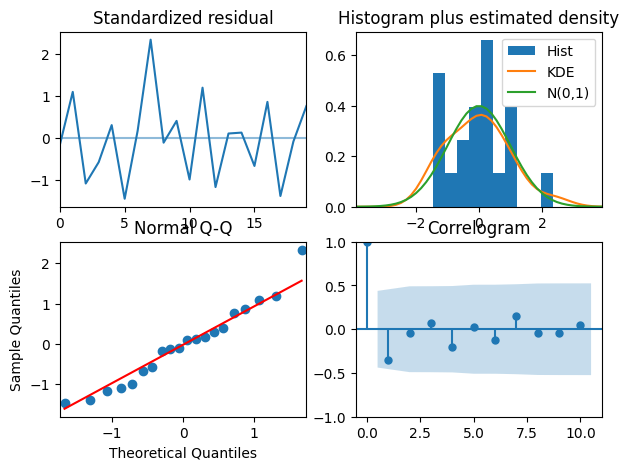

In [27]:
diagnostic_plt(capex_sarima, df_cex)

In [28]:
capex_fc_series=sarima_forecast(capex_sarima, df_cex, num_periods=5, company=company)
capex_fc_list=capex_fc_series.tolist()
capex_fc_list

[-4619382518.761072,
 -4798692361.896097,
 -4934077060.238076,
 -5076844277.341127,
 -5266538818.81813]

<b>Change in Working Capital (CWC)</b>

2023-04-16 14:11:38,303 - root - 122 - INFO - You´ve chosen three orders of Differencing


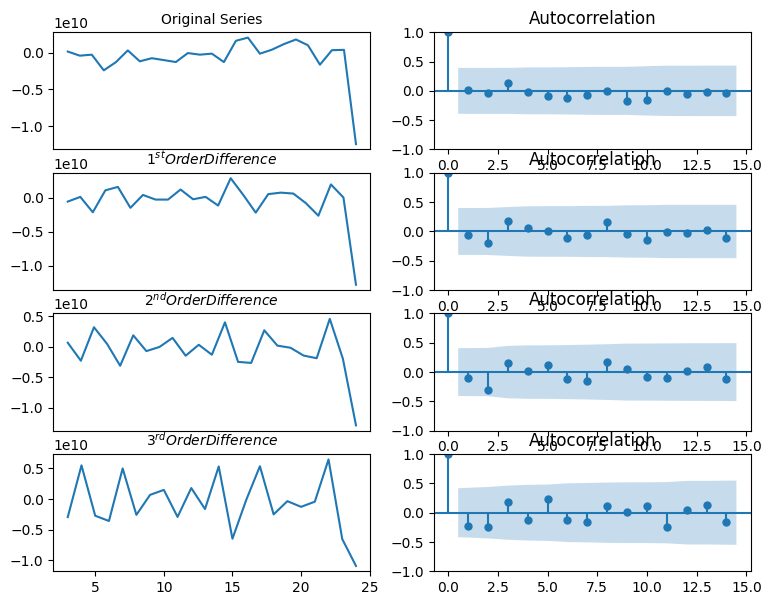

In [29]:
df_cwc=comp_cwc[['value']].sort_values('date', ascending=True).reset_index().drop(['date'], axis=1)
plot_autocorr(df_cwc, diff=3)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,1,1)[3]             : AIC=934.670, Time=0.04 sec
 ARIMA(0,2,0)(0,1,0)[3]             : AIC=938.139, Time=0.00 sec
 ARIMA(1,2,0)(1,1,0)[3]             : AIC=940.550, Time=0.01 sec
 ARIMA(0,2,1)(0,1,1)[3]             : AIC=932.840, Time=0.02 sec
 ARIMA(0,2,1)(0,1,0)[3]             : AIC=932.888, Time=0.01 sec
 ARIMA(0,2,1)(1,1,1)[3]             : AIC=934.649, Time=0.04 sec
 ARIMA(0,2,1)(0,1,2)[3]             : AIC=934.654, Time=0.03 sec
 ARIMA(0,2,1)(1,1,0)[3]             : AIC=933.751, Time=0.02 sec
 ARIMA(0,2,1)(1,1,2)[3]             : AIC=936.649, Time=0.05 sec
 ARIMA(0,2,0)(0,1,1)[3]             : AIC=940.341, Time=0.01 sec
 ARIMA(0,2,2)(0,1,1)[3]             : AIC=936.643, Time=0.04 sec
 ARIMA(1,2,0)(0,1,1)[3]             : AIC=938.526, Time=0.03 sec
 ARIMA(1,2,2)(0,1,1)[3]             : AIC=938.485, Time=0.07 sec
 ARIMA(0,2,1)(0,1,1)[3] intercept   : AIC=936.982, Time=0.04 sec

Best model:  ARIMA(0,2,1)(0,1,1)[3]          


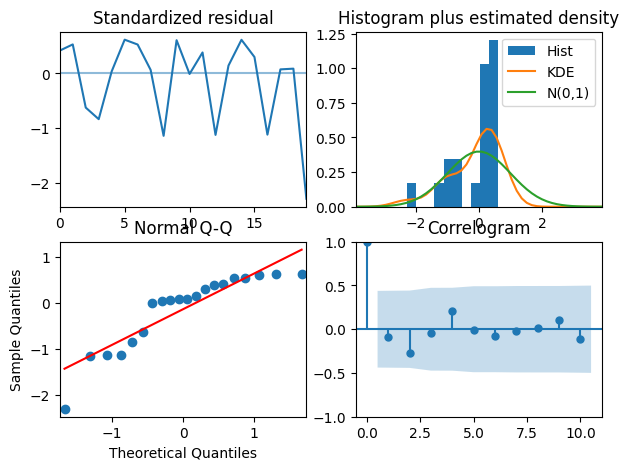

In [30]:
cwc_sarima, summary_cwc=build_sarima(df_cwc)
diagnostic_plt(cwc_sarima, df_cwc)

In [31]:
cwc_fc_series=sarima_forecast(cwc_sarima, df_cwc, num_periods=5, company=company)
cwc_fc_list=cwc_fc_series.tolist()
cwc_fc_list

[-11225471064.823338,
 -11870068236.233355,
 -30646024619.414326,
 -30694747126.083084,
 -32629595739.338524]

---

In [32]:
#=== NET DEBT
mask_nd=bs_y['item'].values=='netDebt'
net_debt=round(float(bs_y.loc[mask_nd, 'value'])/1000,0)
#=== CASH
mask_cash=bs_y['item'].values=='cashAndShortTermInvestments'
cash=round(float(bs_y.loc[mask_cash, 'value'])/1000, 0)

#### Calculation Method

We calculate the unlevered FCF as follows. Please find the picture below:

![dcf](assets/dcf.png)

The terminal value is calculate $uFCF_T*(1+g)/(WACC-g)$, where $g$ is the long-term growth rate (perpetual growth rate) and $uFCF_T$ is the last period uFCF.

In [33]:
# Long-term growth rate, g
g=(wacc-0.025)
# Now, make forecast list for UNLEVERED FREE CASHFLOW through which the random variables as defined above, 
# i.e. the variables and their items which calculate unlevered free cashflow, will flow
def forecast_ufcf(last_rev, rev_cagr, margin_mean, tax, dna_fc_list, capex_fc_list, cwc_fc_list, wacc, g, multiple=8):
    forecast_lst=[]
    for i in range(len(dna_fc_list)):
        if i < len(dna_fc_list)-1:
            ufcf_t=round(float(((last_rev*(1+rev_cagr)**(i+1))*margin_mean)*(1-tax)+dna_fc_list[i]/1000+capex_fc_list[i]/1000-cwc_fc_list[i]/1000)/1000,0)
            forecast_lst.append(ufcf_t)
        else :
            tv_pg=round(float(((((last_rev*(1+rev_cagr)**(i))*margin_mean)*(1-tax)+dna_fc_list[i]+capex_fc_list[i]-cwc_fc_list[i])*(1+g))/(wacc-g))/1000,0)
            ebitda_last=float(((last_rev*(1+rev_cagr)**(i))*margin_mean)+dna_fc_list[i])
            tv_multiple=round(float(ebitda_last*multiple)/1000,0)
            tv=(tv_pg+tv_multiple)/2
            forecast_lst.append(tv)
    return forecast_lst

In [34]:
forecast=forecast_ufcf(end_val, rev_cagr, oir_mean, tax, dna_fc_list, capex_fc_list, cwc_fc_list, wacc, g)
forecast

[546039.0, 561135.0, 593144.0, 606066.0, 679751605.5]

In [35]:
# Now calculate the Present Value of the Free Cash Flows and the terminal value
# Function to discount the free cash flows and the terminal value
# I changed the function a bit as compared to https://towardsdatascience.com/company-valuation-using-probabilistic-models-with-python-712e325964b7
# because I calculated the terminal value already before in the forecast list!
def get_pv(forecast, wacc):
    discount_lst = []
    for x,i in enumerate(forecast):
        if x < 5:
            discount_lst.append(i/(1+wacc)**(x+1))
        else:
            discount_lst.append(i*(1/(1+wacc)**5))
    return sum(discount_lst)
intrinsic_value=round(float(get_pv(forecast, wacc)+cash-net_debt),0)
intrinsic_value

591000142.0

In [36]:
outstanding_shares=get_profile_data(ticker, json_entry='outstandingShares', entry_point='shares')/1000
current_share_price=get_profile_data(ticker, json_entry='price', entry_point='profile')
intrinsic_share_price=round(intrinsic_value/outstanding_shares,2)

if current_share_price > intrinsic_share_price:
    print(f'The company {company} seems to be overrated on the market. The market price exceeds the estimated intrinsic equity price per share:\n--------------------------\nMarket Price: {current_share_price}\nIntrinsic Share Price: {intrinsic_share_price}\n--------------------------')
else:
    print(f'The company {company} seems to be underrated on the market. The market price is below the estimated intrinsic equity price per share:\n--------------------------\nMarket Price: {current_share_price}\nIntrinsic Share Price: {intrinsic_share_price}\n--------------------------')

The company E.ON SE seems to be underrated on the market. The market price is below the estimated intrinsic equity price per share:
--------------------------
Market Price: 11.76
Intrinsic Share Price: 226.4
--------------------------


### Run Monte Carlo Simulation

In [37]:
'''----// Run simulation: Monte Carlo //----'''
iterations=1000
hist_lst = []
# the rolling averages remain  the same; just change the input parameters like cagrs, operating margin mean, wacc and g (long-term growth)
for i in range(iterations):
    cagr = np.random.normal(rev_cagr, 0.01)
    margin = np.random.normal(oir_mean, 0.005)
    long_term_rate = np.random.normal(g, 0.001)
    discount_rate = np.random.normal(wacc, 0.001)
    forecast = forecast_ufcf(end_val, cagr, margin, tax, dna_fc_list, capex_fc_list, cwc_fc_list, discount_rate, long_term_rate)
    hist_lst.append(round(float(get_pv(forecast, discount_rate)+cash-net_debt),0))
hist_array = np.array(hist_lst)

In [38]:
mean = hist_array.mean() # mean of the sampled point estimates
standard_error = hist_array.std()/(iterations**(1/2)) # sample standard error

lower_bound = mean-1.96*standard_error
upper_bound = mean+1.96*standard_error

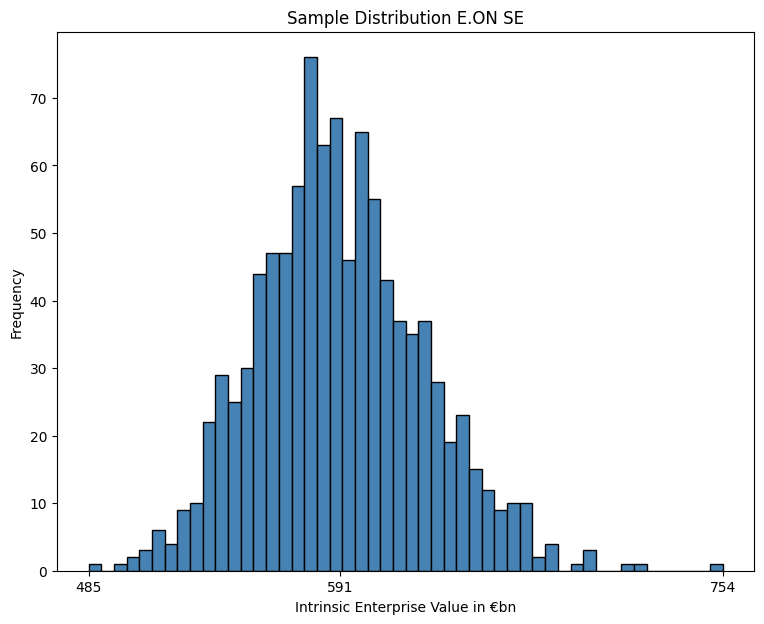

In [39]:
x_ticks = [min(hist_array), hist_array.mean(), max(hist_array)]
x_labels=[int(min(hist_array)/1000000), int(hist_array.mean()/1000000), int(max(hist_array)/1000000)]
plt.hist(hist_array, bins=50, align='mid', color = 'steelblue', edgecolor='black')
plt.title('Sample Distribution ' + company);
plt.xlabel('Intrinsic Enterprise Value in €bn');
plt.ylabel('Frequency');
plt.xticks(x_ticks, x_labels)
plt.savefig('assets/mc_sample.png', bbox_inches='tight')
plt.show()

---

STUFF FOR TESTING PURPOSES ONLY!

In [40]:
# Retrieve company data for sector-stock matching
sql="""SELECT * FROM company"""
try:
    company_df=pd.read_sql(sql, engine)
    pd.set_option('display.expand_frame_repr', False)
    logger.info("You have successfully retrieved the company data!")
except Exception as ex:
    logger.info("Sorry! Something went wrong! I guess, there is no data available. Have you stored the data in the database?\n"+ ex)
print(company_df)


# Creating a dictionary with the economic sectors with their respective stocks. Thereafter we'll convert it into
# a json file so we don't need to read the data source page multiple times.
subdf=company_df[["symbol", "sector"]]

stocks_sectors_dict=subdf.to_dict(orient='list')
#print(stocks_sectors_dict)

# Implementing the economic sector names as the dictionary key and their stocks as values.
d = {}
for stock, sector in zip(stocks_sectors_dict['symbol'], stocks_sectors_dict['sector']):
    if sector not in d.keys():
        d[sector] = [stock]
    else:
        d[sector].append(stock)

# Converting it into a json file
with open("sector_stocks.json", "w") as outfile:
    json.dump(d, outfile)

#=== Stock-currency Mapping
subdf_curr=company_df[["symbol", "currency"]]

stocks_curr_dict=subdf_curr.to_dict(orient='list')
#print(stocks_sectors_dict)

# Implementing the stock names as the dictionary key and their currency as values.
d_curr = {}
for stock, curr in zip(stocks_curr_dict['symbol'], stocks_curr_dict['currency']):
    if curr not in d_curr.keys():
        d_curr[curr] = [stock]
    else:
        d_curr[curr].append(stock)

# Converting it into a json file
with open("stocks_curr.json", "w") as outfile_curr:
    json.dump(d_curr, outfile_curr)

#===Stock-Exchange Mapping
subdf_stex=company_df[["symbol", "exchangeshortname"]]

stocks_exch_dict=subdf_stex.to_dict(orient='list')
#print(stocks_sectors_dict)

# Implementing the stock names as the dictionary key and their currency as values.
d_stex = {}
for stock, exchange in zip(stocks_exch_dict['symbol'], stocks_exch_dict['exchangeshortname']):
    if exchange not in d_stex.keys():
        d_stex[exchange] = [stock]
    else:
        d_stex[exchange].append(stock)

# Converting it into a json file
with open("stocks_exchange.json", "w") as outfile_exchange:
    json.dump(d_stex, outfile_exchange)

# Prepare ticker list for making web request with pandas DataReader
tickers=company_df['symbol'].values.tolist()

# A function that is going to retrieve the stocks' price variation.
end=date.today()
def variation(ticker):
    df = get_price_table(ticker) # from my fmp-package
    return df['changePercent'].iloc[0] # the latest percentage change value is in first row in column 'changePercent' --> FMP delivers it! Easy!

carousel_prices = {}
for stock in tickers:
    # Calculating the stocks' price variation and storing it in the 'carousel_prices' dictionary.
    carousel_prices[stock] = variation(stock)

# Turning 'carousel_prices' into a json file.
with open('carousel_prices.json', 'w') as outfile:
    json.dump(carousel_prices, outfile)

# Loading the dashboard's json files.
sector_stocks = json.load(open('sector_stocks.json', 'r'))
carousel_prices = json.load(open('carousel_prices.json', 'r'))
stocks_curr = json.load(open('stocks_curr.json', 'r'))
stocks_exch=json.load(open('stocks_exchange.json', 'r'))

2023-04-16 14:11:41,399 - root - 6 - INFO - You have successfully retrieved the company data!
    id                         shortname   symbol                        industry                  sector currency exchangeshortname  bs_id  is_id  cs_id
0    0                       GitLab Inc.     GTLB            Software—Application              Technology      USD            NASDAQ    211    147    155
1    1        Palantir Technologies Inc.     PLTR         Software—Infrastructure              Technology      USD              NYSE    476    332    350
2    2          Infineon Technologies AG   IFX.DE                  Semiconductors              Technology      EUR             XETRA   1801   1257   1325
3    3                           E.ON SE  EOAN.DE           Utilities—Diversified               Utilities      EUR             XETRA   3126   2182   2300
4    4           Siemens Healthineers AG   SHL.DE                 Medical Devices              Healthcare      EUR             XETRA   3

In [41]:
import plotly.graph_objects as go
CHART_THEME='plotly_white'
curr=[key for key, tickers_list in stocks_curr.items() if ticker in tickers_list][0]

mc_fig=go.Figure()
mc_fig.add_trace(go.Histogram(x=hist_array/1000000, name=f'Intrinsic Valuation: {company}',marker_color='#EB89B5'))
mc_fig.layout.template=CHART_THEME
mc_fig.update_layout(
    title={
    'text': f'Intrinsic EV - Monte Carlo Simulation: {company}',
    'y':0.95,
    'x': 0.5,
    'xanchor':'center',
    'yanchor': 'top'
    },
    xaxis=dict(
        title=f"Intrinsic Enterprise Value in {curr}bn",
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=14,
            color='rgb(136, 136, 138)',
        ),
    ),
    yaxis=dict(
        title="Count",
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        zeroline=False,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=14,
            color='rgb(136, 136, 138)',
        ),
    ),
    margin=dict(
        b=50,
        l=25,
        r=25,
        t=50
    ),
    # plot_bgcolor='black',
    # paper_bgcolor='black',
    # font_color='grey',
    # autosize=True
)
mc_fig.show()

In [42]:
# get company beta value from FMP
# For the extract function I used the code of this colleague instead of working it out on my own (sorry! too lazy!)
# https://python.plainenglish.io/extracting-specific-keys-values-from-a-messed-up-json-file-python-dfb671482681
def extract(data, keys):
    out = []
    queue = [data]
    while len(queue) > 0:
        current = queue.pop(0)
        if type(current) == dict:
            for key in keys:
                if key in current:
                    out.append({key:current[key]})
            
            for val in current.values():
                if type(val) in [list, dict]:
                    queue.append(val)
        elif type(current) == list:
            queue.extend(current)
    return out
def get_price_table(ticker, json_entry='historical'):
    """Get historical daily price data"""
    my_api_key=MY_API_KEY
    entrypoint="https://financialmodelingprep.com/api/v3/historical-price-full/"
    headers = {'Accept': 'application/json'}
    
    # Now make request to FMP API
    requestUrl=entrypoint+ ticker + "?apikey=" + my_api_key
    response = requests.get(requestUrl)#, headers=headers)
    assert response.status_code == 200, f"Expected response code 200, got {response.status_code} for {requestUrl}. Check again your url!"
    # use the .json() method offered by 'requests' package: https://datagy.io/python-requests-json/
    response_list=response.json()
    entry=extract(response_list, [json_entry])
    entry=entry[0][json_entry]
    df=pd.DataFrame(entry)
    return df
aapl=get_price_table(ticker)
aapl

,date,open,high,low,close,adjClose,volume,unadjustedVolume,change,changePercent,vwap,label,changeOverTime
0,2023-04-14,11.950,11.975,11.745,11.760,11.760000,7666344,7666344,-0.190,-1.590000,11.83,"April 14, 23",-0.015900
1,2023-04-13,11.925,11.930,11.800,11.865,11.865000,4169087,4169087,-0.060,-0.503140,11.87,"April 13, 23",-0.005031
2,2023-04-12,11.800,11.935,11.795,11.885,11.885000,4763168,4763168,0.085,0.720340,11.87,"April 12, 23",0.007203
3,2023-04-11,11.790,11.850,11.755,11.795,11.795000,3920043,3920043,0.005,0.042409,11.80,"April 11, 23",0.000424
4,2023-04-06,11.635,11.785,11.605,11.715,11.715000,3956296,3956296,0.080,0.687580,11.70,"April 06, 23",0.006876
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1264,2018-04-23,8.938,8.944,8.846,8.848,6.871588,11334148,11334148,-0.090,-1.010000,8.88,"April 23, 18",-0.010100
1265,2018-04-20,9.070,9.070,8.838,8.938,6.941485,17713798,17713798,-0.132,-1.460000,8.95,"April 20, 18",-0.014600
1266,2018-04-19,9.100,9.116,9.003,9.036,7.017594,10523729,10523729,-0.064,-0.703300,9.05,"April 19, 18",-0.007033
1267,2018-04-18,9.014,9.137,8.977,9.117,7.080501,12608767,12608767,0.103,1.140000,9.08,"April 18, 18",0.011400


In [43]:
aapl['date'].iloc[0][5:7]

'04'

In [44]:
variation=aapl['changePercent'].iloc[0]
variation

-1.59

In [45]:
import plotly.graph_objects as go

# The standard stock displayed when the dashboard is initialized will be Infineon, IFX.DE.
standard_disp = get_price_table(ticker)

# 'standard_disp_variation' is stored inside the card that shows the stock's current price.
standard_disp_variation = standard_disp['changePercent'].iloc[0]

#====================================================#
# START STYLING OF APP
#====================================================#

# 'fig' exposes a candlestick chart with the prices of the stock since 2015.
fig = go.Figure()
fig.add_trace(go.Candlestick(x=standard_disp['date'],
                             open=standard_disp['open'],
                             close=standard_disp['close'],
                             high=standard_disp['high'],
                             low=standard_disp['low'],
                             name='Stock Price'))
fig.update_layout(
    plot_bgcolor='rgb(50, 50, 50)',
    paper_bgcolor='black', # check colors here: https://plotly.com/python-api-reference/generated/plotly.graph_objects.layout.html
    font_color='white',
    height=500,
    width=1020,
    margin=dict(l=10, r=10, b=5, t=5),
    autosize=False,
    showlegend=False
)

# Setting the graph to display the current prices in a first moment. Nonetheless,the user can also manually ajust the zoom size
# either by selecting a section of the chart or using one of the time span buttons available.
# The default
min_date = '2021-01-01'
max_date = end
fig.update_xaxes(range=[min_date, end])
fig.update_yaxes(tickprefix=[key for key, tickers_list in stocks_curr.items() if ticker in tickers_list][0]+' ')

In [46]:
from pandas_ta import bbands
price_table = get_price_table('IFX.DE').sort_values("date", ascending=True)
# Bollinger Bands (normally distributed price fluctuations)
df_bbands = bbands(price_table['close'], length=20, std=2)
# Measuring Rolling and Exponential Rolling Mean (moving averages!)
price_table['Simple_Moving_Avrg'] = price_table['close'].rolling(window=5).mean()
price_table['Exponential_Moving_Avrg'] = price_table['close'].ewm(span=5, adjust=True).mean()
df_bbands

,BBL_20_2.0,BBM_20_2.0,BBU_20_2.0,BBB_20_2.0,BBP_20_2.0
1268,NaN,NaN,NaN,NaN,NaN
1267,NaN,NaN,NaN,NaN,NaN
1266,NaN,NaN,NaN,NaN,NaN
1265,NaN,NaN,NaN,NaN,NaN
1264,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
4,32.716432,35.21000,37.703568,14.163975,0.517043
3,32.708238,35.19575,37.683261,14.135294,0.525980
2,32.831111,35.26950,37.707889,13.827180,0.559568
1,32.866644,35.33675,37.806856,13.980378,0.687897


In [47]:
from ValuationModel.dcf import build_dcf_model
company='The Coca-Cola Company'
fig_mc, intrinsic_value, intrinsic_price=build_dcf_model(company=company, year=2022, tax_rate=0.15825)
fig_mc.show()

2023-04-16 14:12:01,501 - root - 95 - INFO - You have successfully created an engine object for your Postgres DB at localhost for user svenst89!
2023-04-16 14:12:01,560 - root - 105 - INFO - You have successfully retrieved the company data!
You have successfully retrieved the financial statement data for company 'The Coca-Cola Company'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Income Statement and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Cashflow Statement and extracted financial data for Fiscal Year (FY) 2022.

You have successfully retrieved the financial statement data for company 'The Coca-Cola Company'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

You have successfully retrieved the company data for company '   id              shortname symbol                 industry              sector currency exchangeshortname  bs_id  is_id  cs_id
0   8  T

In [48]:
intrinsic_price

51.98

In [1]:
import datetime
from datetime import date
from datetime import datetime

today=date.today()

In [2]:
datetime.strptime(today.strftime('%m'), '%m')

datetime.datetime(1900, 4, 1, 0, 0)

In [3]:
int(today.strftime('%Y'))

2023

In [52]:
my_api_key=MY_API_KEY
entrypoint_profile="https://financialmodelingprep.com/api/v4/sector_price_earning_ratio?"
headers = {'Accept': 'application/json'}
today=date.today().strftime('%Y-%m-%d') # date today in format 'YYYY-05-11'
    
# Now make request to FMP API
requestUrl= entrypoint_profile + 'date=' + today + '&exchange=' + exchange + "&" +  "apikey=" + my_api_key
response = requests.get(requestUrl)#, headers=headers)
assert response.status_code == 200, f"Expected response code 200, got {response.status_code} for {requestUrl}. Check again your url!"
# use the .json() method offered by 'requests' package: https://datagy.io/python-requests-json/
response_list=response.json()
response_list

[]

In [53]:
range(len(response_list))

range(0, 0)

In [54]:
def extract(data, keys):
    out = []
    queue = [data]
    while len(queue) > 0:
        current = queue.pop(0)
        if type(current) == dict:
            for key in keys:
                if key in current:
                    out.append({key:current[key]})
            
            for val in current.values():
                if type(val) in [list, dict]:
                    queue.append(val)
        elif type(current) == list:
            queue.extend(current)
    return out
sector=[key for key, tickers_list in sector_stocks.items() if ticker in tickers_list][0]
for i in range(len(response_list)):
    for key, value in response_list[i].items():
        dict_sector=sector
        if dict_sector == value:
            entry=extract(response_list, ['pe'])
            entry=entry[0]['pe']

In [55]:
entry

[{'date': 1262592000,
  'high': 6048.2998046875,
  'low': 5974.43017578125,
  'open': 5975.52001953125,
  'close': 6048.2998046875,
  'volume': 104344400,
  'adjclose': 6048.2998046875,
  'formatted_date': '2010-01-04'},
 {'date': 1262678400,
  'high': 6058.02001953125,
  'low': 6015.669921875,
  'open': 6043.93994140625,
  'close': 6031.85986328125,
  'volume': 117572100,
  'adjclose': 6031.85986328125,
  'formatted_date': '2010-01-05'},
 {'date': 1262764800,
  'high': 6047.56982421875,
  'low': 5997.08984375,
  'open': 6032.39013671875,
  'close': 6034.330078125,
  'volume': 108742400,
  'adjclose': 6034.330078125,
  'formatted_date': '2010-01-06'},
 {'date': 1262851200,
  'high': 6037.56982421875,
  'low': 5961.25,
  'open': 6016.7998046875,
  'close': 6019.35986328125,
  'volume': 133704300,
  'adjclose': 6019.35986328125,
  'formatted_date': '2010-01-07'},
 {'date': 1262937600,
  'high': 6053.0400390625,
  'low': 5972.240234375,
  'open': 6028.6201171875,
  'close': 6037.609863281

In [56]:
from ValuationModel.fmp import *
from ValuationModel.assist_functions import *
from ValuationModel.dcf import *
company=get_profile_data('EOAN.DE', json_entry='companyName', entry_point='profile')
latest_year=get_latest_available_fy('EOAN.DE', json_entry="date")
fig_mc, intrinsic_value, intrinsic_price=build_dcf_model(company=company, year=latest_year, tax_rate=0.15825)

2023-04-16 14:12:09,330 - root - 286 - INFO - I will return last year´s data as the company has not yet published...
2023-04-16 14:12:09,331 - root - 288 - INFO - For EOAN.DE I returned as latest available year: 2022.
2023-04-16 14:12:09,332 - root - 95 - INFO - You have successfully created an engine object for your Postgres DB at localhost for user svenst89!
2023-04-16 14:12:09,383 - root - 105 - INFO - You have successfully retrieved the company data!
You have successfully retrieved the financial statement data for company 'E.ON SE'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Income Statement and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Cashflow Statement and extracted financial data for Fiscal Year (FY) 2022.

You have successfully retrieved the financial statement data for company 'E.ON SE'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

You have 

In [57]:
company='E.ON SE'
bs, incs, cs = get_database_findata(company, engine)
bs_y=clearDataframes_and_get_fy(company, bs, 'bs', year)
incs_y=clearDataframes_and_get_fy(company, incs, 'incs', year)
cs_y=clearDataframes_and_get_fy(company, cs, 'cs', year)

#=== CALCULATE WACC
# The equity required rate of return is calculated and Beta is retrieved inside this function!
wacc=get_wacc(company, year, rfr, mrp, at_debt_cost, engine)

You have successfully retrieved the financial statement data for company 'E.ON SE'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Income Statement and extracted financial data for Fiscal Year (FY) 2022.

==> I revised the Cashflow Statement and extracted financial data for Fiscal Year (FY) 2022.

You have successfully retrieved the financial statement data for company 'E.ON SE'!
==> I revised the Balance Sheet and extracted financial data for Fiscal Year (FY) 2022.

You have successfully retrieved the company data for company '   id shortname   symbol               industry     sector currency exchangeshortname  bs_id  is_id  cs_id
0   3   E.ON SE  EOAN.DE  Utilities—Diversified  Utilities      EUR             XETRA   3126   2182   2300'!


In [1]:
from ValuationModel.assist_functions import market_correlation
import json
ticker = 'IFX.DE'
stocks_exch=json.load(open('stocks_exchange.json', 'r'))
stock_exchange = [key for key, ticker_list in stocks_exch.items() if ticker in ticker_list][0]
if stock_exchange == 'NASDAQ':
    _index='^NDX'
elif stock_exchange == 'NYSE':
    _index='^NYA'
elif stock_exchange == 'XETRA':
    _index = '^GDAXI'
else:
    _index = '^GSPC'
m_corr = market_correlation(ticker, _index)

snp: 
               close
count    256.000000
mean   13985.119595
std      996.623617
min    11975.549805
25%    13188.230225
50%    13953.625000
75%    14824.712646
max    15807.500000
stock_close: 
             close
count  256.000000
mean    28.692617
std      4.251669
min     21.065001
25%     24.828750
50%     27.735000
75%     32.056250
max     37.840000


In [8]:
from scipy.stats import pearsonr
import datetime
from datetime import date
from datetime import timedelta
from yahoofinancials import YahooFinancials
index = '^GDAXI'
ticker = 'IFX.DE'
start = date.today() - \
        timedelta(days=int(365))
end = date.today()
start = start.strftime("%Y-%m-%d")

today = date.today()        # get the date of today
today_formatted = today.strftime("%Y-%m-%d")
dax_perf_prices = YahooFinancials(index).get_historical_price_data(start, end_date=today_formatted, time_interval='daily')
#dax_perf_prices = pd.DataFrame.from_dict(pd.json_normalize(dax_perf_prices), orient="columns")
entry=extract_json(dax_perf_prices, ['prices'])
entry=entry[0]['prices']
index=pd.DataFrame(entry)
#dax=get_price_table('DAX', json_entry='historical')
snp=index[['close']]
print(f"snp: \n {snp.describe()}")

# get stock table
stock_price = get_price_table(ticker).sort_values("date", ascending=True)
stock_close = stock_price[(stock_price['date']>=start) &  (stock_price['date']<=today_formatted)][['close']].reset_index().drop('index', axis=1)
stock_close


snp: 
               close
count    256.000000
mean   13985.119595
std      996.623617
min    11975.549805
25%    13188.230225
50%    13953.625000
75%    14824.712646
max    15807.500000


,close
0,27.680000
1,28.320000
2,28.320000
3,28.320000
4,27.885000
...,...
251,35.294998
252,35.325001
253,35.560001
254,36.264999


In [9]:
snp

,close
0,14153.459961
1,14362.030273
2,14502.410156
3,14142.089844
4,13924.169922
...,...
251,15597.889648
252,15655.169922
253,15703.599609
254,15729.459961


In [11]:
pearsonr(snp['close'], stock_close.close)[0]

0.955602492673804

In [5]:
import plotly.graph_objects as go
import plotly.io as pio
plotly_template = pio.templates["plotly_dark"]
print (plotly_template)

layout.Template({
    'data': {'bar': [{'error_x': {'color': '#f2f5fa'},
                      'error_y': {'color': '#f2f5fa'},
                      'marker': {'line': {'color': 'rgb(17,17,17)', 'width': 0.5},
                                 'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
                      'type': 'bar'}],
             'barpolar': [{'marker': {'line': {'color': 'rgb(17,17,17)', 'width': 0.5},
                                      'pattern': {'fillmode': 'overlay', 'size': 10, 'solidity': 0.2}},
                           'type': 'barpolar'}],
             'carpet': [{'aaxis': {'endlinecolor': '#A2B1C6',
                                   'gridcolor': '#506784',
                                   'linecolor': '#506784',
                                   'minorgridcolor': '#506784',
                                   'startlinecolor': '#A2B1C6'},
                         'baxis': {'endlinecolor': '#A2B1C6',
                                   'gri